In [1]:
#define custom activation 
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.activations import tanh
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.callbacks import TensorBoard
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D,GRU
from tensorflow import tanh
from keras import backend as K
from tensorflow.keras.utils import get_custom_objects
class Double_Tanh(Activation): 
    def __init__(self, activation, **kwargs): 
        super(Double_Tanh, self).__init__(activation, **kwargs) 
        self.__name__ = 'double_tanh'
def double_tanh(x): 
    return (tanh(x) * 2) 
get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

# 读取股票数据
data = pd.read_csv('aligned&cleaned.csv')
data_stock=data[data.name=='万科A']

# 选择特征和目标变量
features = ['open','close','high','low','change_ratio','volume','money_netflow', 'money_inflow','money_outflow','net_inflow_rate','change_ratio']
#target = 'change_ratio'

# 数据预处理
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data_stock[features])

# 构建训练集和测试集
def create_dataset(data, look_back=5):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), :-1])
        Y.append(data[i + look_back, -1])
    return np.array(X), np.array(Y)

look_back = 5
X, Y = create_dataset(scaled_data, look_back)

# 划分训练集和测试集
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

model = Sequential()

#model.add(GRU(units=100, return_sequences=True,input_shape=(look_back, len(features))))
#model.add(Dropout(0.1))
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, len(features))))
#model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=80, return_sequences=True))
model.add(LSTM(units=60, return_sequences=True))
model.add(LSTM(units=40, return_sequences=True))
model.add(LSTM(units=20))

model.add(Dense(units=10))
model.add(Activation(tanh))
model.add(Dense(units=1))
input_layer = model.layers[0].input
output_layer = model.layers[-1].output
model = Model(inputs=input_layer, outputs=output_layer)

d:\anaconda\envs\paper\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [2]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 100)         │        44,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 80)          │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 60)          │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5, 40)          │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,821 (616.49 KB)

 Trainable params: 157,821 (616.49 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
from keras.optimizers import SGD

optimizer = SGD(learning_rate=0.01, momentum=0.9)

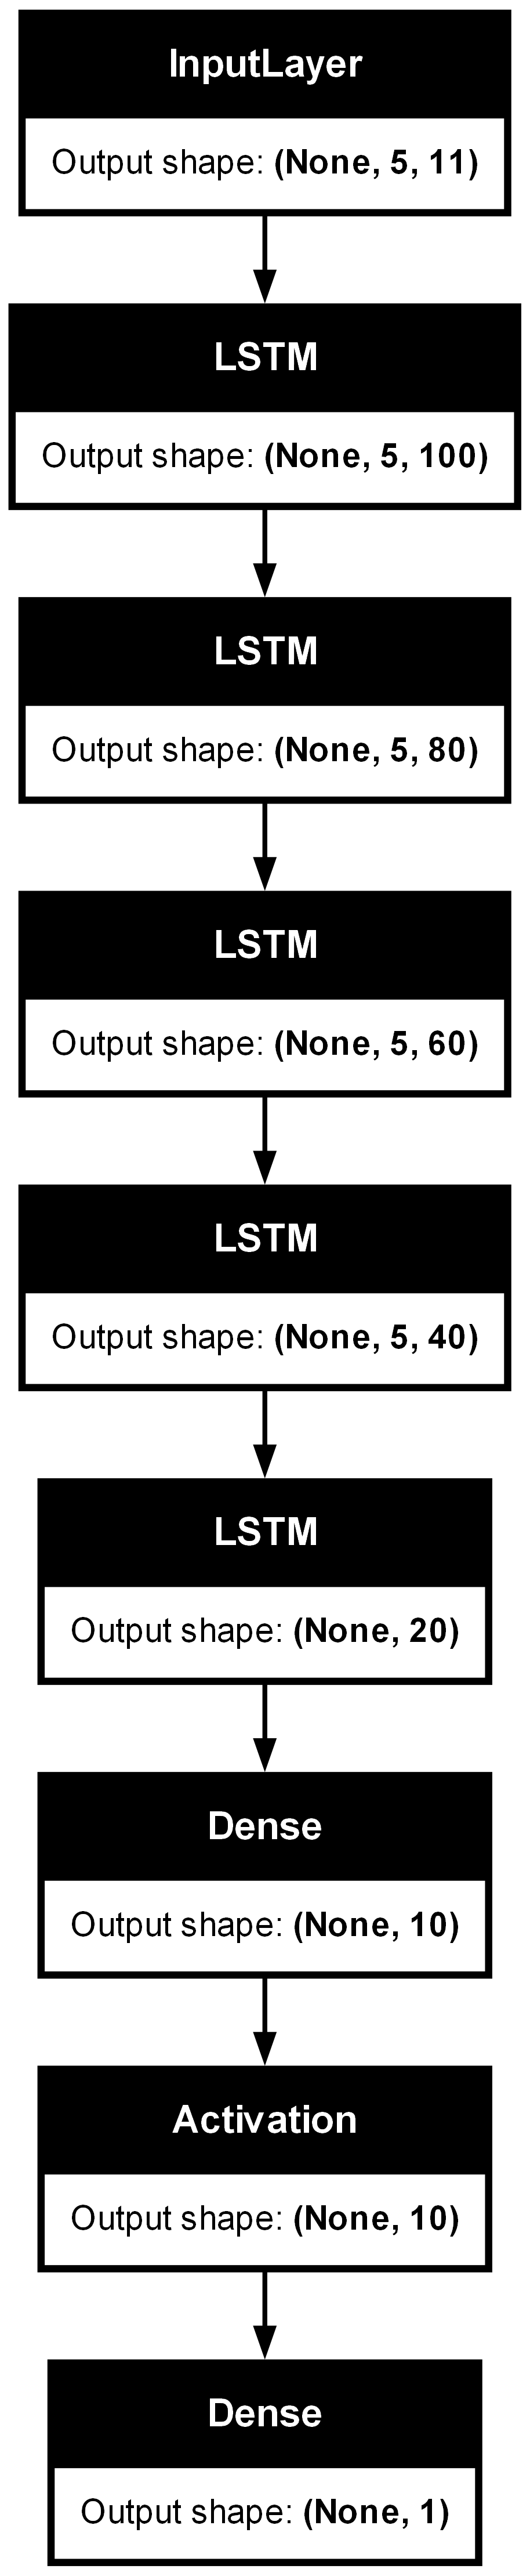

In [4]:
from keras.utils import plot_model

# 在模型训练之前
plot_model(model, to_file='model_structure.png',dpi=300,show_shapes=True)

In [5]:

#model.compile(optimizer='Adam', loss= 'mean_squared_error')
#['mean_absolute_error','mean_squared_error']
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])
tensorboard = TensorBoard(log_dir='log',update_freq=1, histogram_freq=1, write_graph=True, write_images=True)
# 模型训练
model.fit(X_train, Y_train, epochs=800, batch_size=64, verbose=2,callbacks=[tensorboard])

# 模型预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


Epoch 1/800
3/3 - 5s - 2s/step - loss: 0.2057 - mae: 0.4092 - mse: 0.2047
Epoch 2/800
3/3 - 0s - 73ms/step - loss: 0.1696 - mae: 0.3688 - mse: 0.1706
Epoch 3/800
3/3 - 0s - 73ms/step - loss: 0.1270 - mae: 0.3111 - mse: 0.1314
Epoch 4/800
3/3 - 0s - 76ms/step - loss: 0.0935 - mae: 0.2349 - mse: 0.0906
Epoch 5/800
3/3 - 0s - 75ms/step - loss: 0.0842 - mae: 0.2126 - mse: 0.0867
Epoch 6/800
3/3 - 0s - 71ms/step - loss: 0.0878 - mae: 0.2063 - mse: 0.0849
Epoch 7/800
3/3 - 0s - 70ms/step - loss: 0.0725 - mae: 0.1957 - mse: 0.0737
Epoch 8/800
3/3 - 0s - 71ms/step - loss: 0.0766 - mae: 0.2030 - mse: 0.0756
Epoch 9/800
3/3 - 0s - 71ms/step - loss: 0.0785 - mae: 0.2084 - mse: 0.0771
Epoch 10/800
3/3 - 0s - 72ms/step - loss: 0.0727 - mae: 0.2051 - mse: 0.0758
Epoch 11/800
3/3 - 0s - 72ms/step - loss: 0.0709 - mae: 0.1983 - mse: 0.0735
Epoch 12/800
3/3 - 0s - 72ms/step - loss: 0.0769 - mae: 0.1950 - mse: 0.0733
Epoch 13/800
3/3 - 0s - 71ms/step - loss: 0.0738 - mae: 0.1943 - mse: 0.0738
Epoch 14/8

In [6]:
train_score = np.sqrt(np.mean(np.square(train_predict - Y_train)))
test_score = np.sqrt(np.mean(np.square(test_predict - Y_test)))

print(f'Train RMSE: {train_score:.4f}')
print(f'Test RMSE: {test_score:.4f}')

Train RMSE: 0.3811
Test RMSE: 0.3578


In [7]:
# 将 Y_train 和 Y_test 从一维数组转换为二维数组
Y_train_reshaped = Y_train.reshape(-1, 1)
Y_test_reshaped = Y_test.reshape(-1, 1)

# 现在可以安全地进行合并了
Y_train_real = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], Y_train_reshaped), axis=1))[:, -1]
Y_test_real = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], Y_test_reshaped), axis=1))[:, -1]


In [8]:
# 反归一化
train_predict = scaler.inverse_transform(np.concatenate((X_train[:, -1, :-1], train_predict), axis=1))[:, -1]
test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], test_predict), axis=1))[:, -1]



# 评估模型
train_score = np.sqrt(np.mean(np.square(train_predict - Y_train_real)))
test_score = np.sqrt(np.mean(np.square(test_predict - Y_test_real)))

print(f'Train RMSE: {train_score:.4f}')
print(f'Test RMSE: {test_score:.4f}')

Train RMSE: 0.0010
Test RMSE: 0.0230


In [9]:
#train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
#test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

In [10]:
import matplotlib.pyplot as plt
def plot_comparison(sequence1, sequence2):
# 假设有两个序列 sequence1 和 sequence2

    # 创建一个图形和坐标轴
    fig, ax = plt.subplots()

    # 绘制第一个序列的折线图,使用蓝色
    ax.plot(sequence1, color='blue', label='REAL')

    # 绘制第二个序列的折线图,使用红色
    ax.plot(sequence2, color='red', label='PREDICT')

    # 添加图例
    ax.legend()

    # 添加标题和标签
    ax.set_title('Comparison of Two Sequences')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

    # 显示图形
    plt.show()

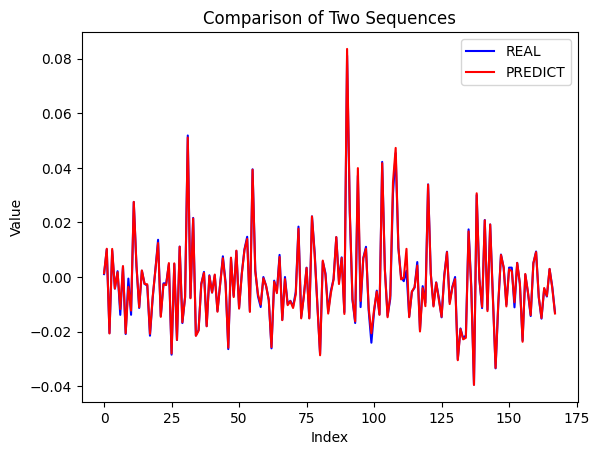

In [11]:
plot_comparison(Y_train_real,train_predict)

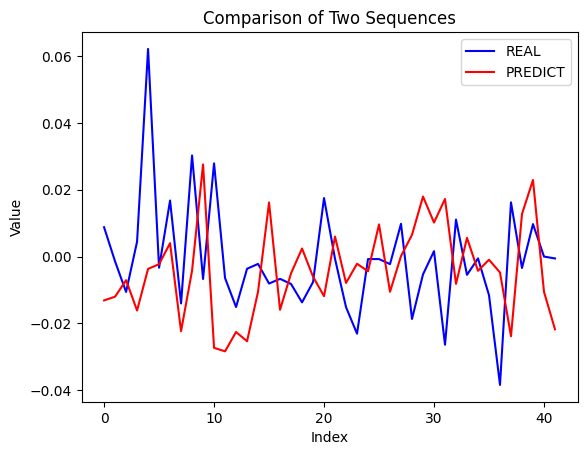

In [12]:
plot_comparison(Y_test_real,test_predict)

In [13]:
def direction_accuracy(y_true, y_pred):
    """
    计算方向准确率(DA)
    
    参数:
    y_true -- 真实值,numpy array
    y_pred -- 预测值,numpy array
    
    返回值:
    da -- 方向准确率,float
    """
    # 计算真实值和预测值的符号(1表示上涨,-1表示下跌)
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    
    # 计算符号相同的样本数量
    correct_samples = np.sum(sign_true == sign_pred)
    
    # 计算总样本数
    total_samples = len(y_true)
    
    # 计算方向准确率
    da = correct_samples / total_samples
    
    return da

In [14]:
direction_accuracy(Y_test_real,test_predict)

0.5476190476190477

In [15]:
direction_accuracy(Y_train_real,train_predict)

0.9761904761904762

In [16]:
def mean_absolute_error(y_true, y_pred):
    """
    计算平均绝对误差(MAE)
    
    参数:
    y_true -- 真实值,numpy array
    y_pred -- 预测值,numpy array
    
    返回值:
    mae -- 平均绝对误差,float
    """
    # 计算预测值和真实值之间的绝对误差
    abs_error = np.abs(y_pred - y_true)
    
    # 计算平均绝对误差
    mae = np.mean(abs_error)
    
    return mae

In [17]:
mean_absolute_error(train_predict,Y_train_real)

0.0005782646761382694

In [18]:
mean_absolute_error(test_predict,Y_test_real)

0.018054555975173456

In [19]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    计算平均绝对百分比误差(MAPE)
    
    参数:
    y_true -- 真实值,numpy array
    y_pred -- 预测值,numpy array
    
    返回值:
    mape -- 平均绝对百分比误差,float
    """
    # 计算预测值和真实值之间的绝对百分比误差
    abs_percentage_error = np.abs((y_pred - y_true) / y_true)
    
    # 计算MAPE
    mape = np.mean(abs_percentage_error) * 100
    
    return mape

In [20]:
mean_absolute_percentage_error(train_predict,Y_train_real)

14.116850729931215

In [21]:
mean_absolute_percentage_error(test_predict,Y_test_real)

410.83602935315895

In [22]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    计算对称平均绝对百分比误差(SMAPE)
    
    参数:
    y_true -- 真实值,numpy array
    y_pred -- 预测值,numpy array
    
    返回值:
    smape -- 对称平均绝对百分比误差,float
    """
    # 计算绝对误差
    abs_error = np.abs(y_pred - y_true)
    
    # 计算绝对误差的平均值
    abs_error_mean = (np.abs(y_pred) + np.abs(y_true)) / 2
    
    # 计算SMAPE
    smape = np.mean(abs_error / abs_error_mean) * 100
    
    return smape

In [23]:
symmetric_mean_absolute_percentage_error(test_predict,Y_test_real)

152.20716277831198

In [24]:
symmetric_mean_absolute_percentage_error(train_predict,Y_train_real)

15.061717716679363

In [25]:
data_stock.change_ratio.describe()

count    216.000000
mean      -0.001497
std        0.016471
min       -0.039437
25%       -0.011327
50%       -0.003191
75%        0.004509
max        0.081159
Name: change_ratio, dtype: float64